In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import os
import tensorflow as tf
from PIL import Image
from numpy import asarray

from keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
from keras.layers import Dense, Input, Dropout, GlobalAveragePooling2D, Flatten, Conv2D, BatchNormalization, Activation, MaxPooling2D
from keras.models import Model, Sequential
from keras.optimizers import Adam, SGD, RMSprop
from keras.utils import to_categorical
from keras.callbacks import ReduceLROnPlateau, EarlyStopping, TensorBoard, ModelCheckpoint
from keras.regularizers import l2

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

from IPython.display import SVG, Image
from livelossplot import PlotLossesKeras

%matplotlib inline

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Mounting google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import zipfile

dataset_path = '/content/drive/MyDrive/combined_balanced_dataset.zip'

with zipfile.ZipFile(dataset_path, 'r') as zip_ref:
    zip_ref.extractall('/content/dataset/')

In [ ]:
picture_size = 48
folder_path = '/content/dataset/content/dataset/combined'

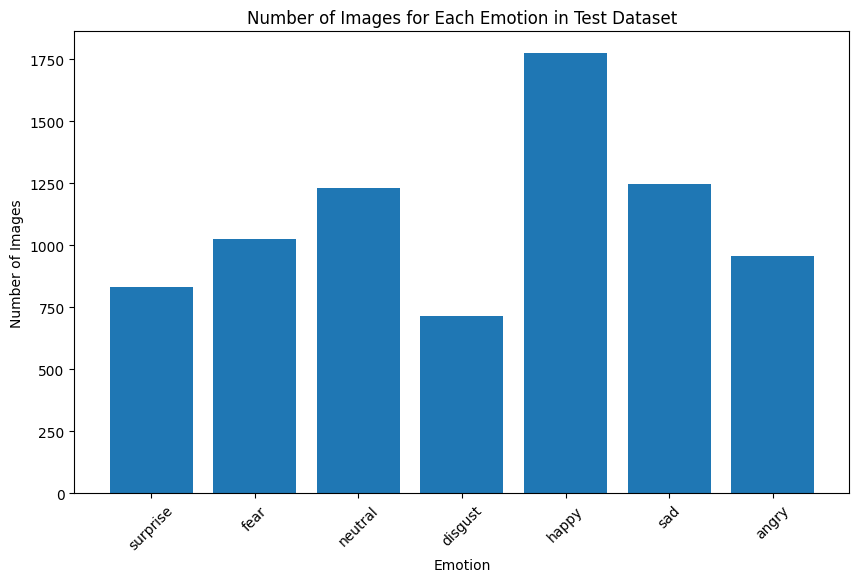

In [ ]:
import os
import cv2

test_dataset_path = '/content/dataset/content/dataset/combined/test'

emotion_counts = {}

emotions = os.listdir(test_dataset_path)


for emotion in emotions:
    emotion_path = os.path.join(test_dataset_path, emotion)
    image_count = len([file for file in os.listdir(emotion_path) if file.endswith('.jpg')])
    emotion_counts[emotion] = image_count


plt.figure(figsize=(10, 6))
plt.bar(emotion_counts.keys(), emotion_counts.values())
plt.xlabel('Emotion')
plt.ylabel('Number of Images')
plt.title('Number of Images for Each Emotion in Test Dataset')
plt.xticks(rotation=45)
plt.show()


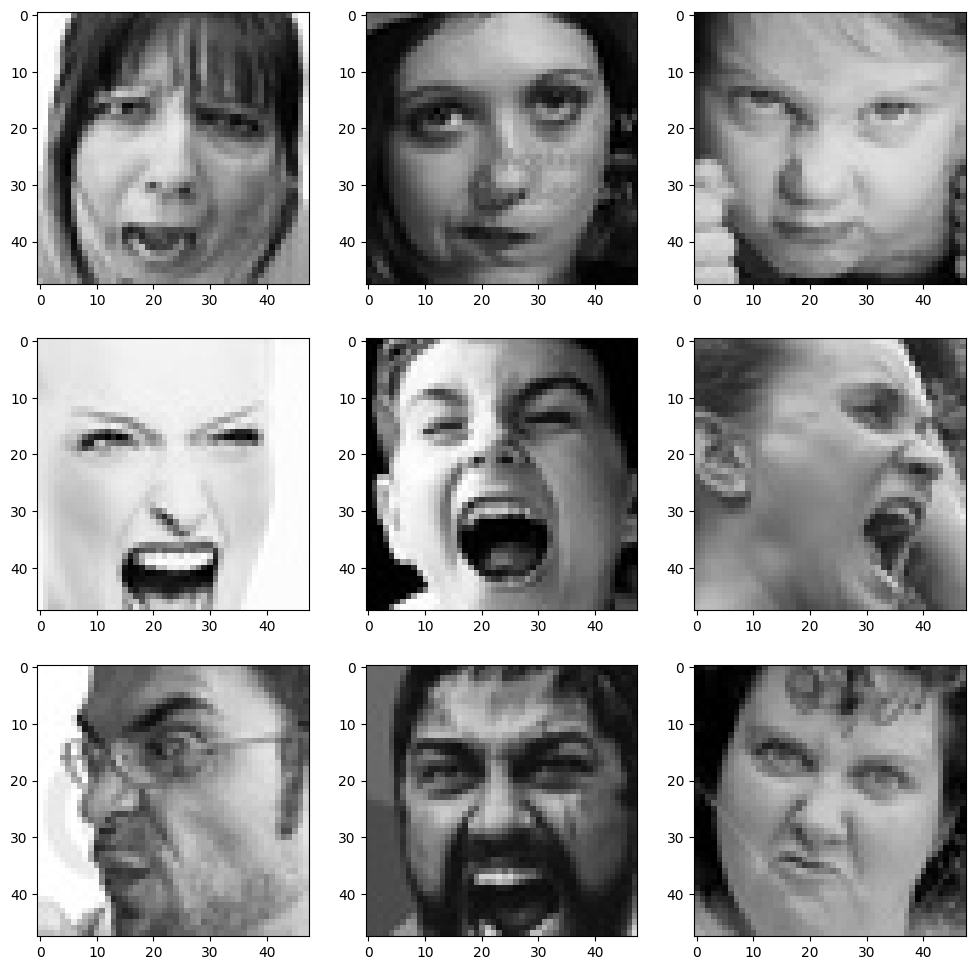

In [ ]:
expression = 'angry'

plt.figure(figsize=(12, 12))
for i in range(1, 10, 1):
    plt.subplot(3, 3, i)
    img_path = os.path.join(folder_path, 'train', expression, os.listdir(os.path.join(folder_path, 'train', expression))[i])
    img = load_img(img_path, target_size=(picture_size, picture_size))
    plt.imshow(img)
plt.show()

from PIL import Image

In [ ]:
import os
import numpy as np
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator

batch_size = 100
picture_size = 48

# Training set data generator
datagen = ImageDataGenerator()

train_set = datagen.flow_from_directory(
    '/content/dataset/content/dataset/combined/train',
    target_size=(picture_size, picture_size),
    color_mode="grayscale",
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)



test_data_dir = '/content/dataset/content/dataset/combined/test'
file_paths = [os.path.join(dp, f) for dp, dn, filenames in os.walk(test_data_dir) for f in filenames if os.path.splitext(f)[1].lower() in ['.png', '.jpg', '.jpeg']]


file_paths_val, file_paths_test = train_test_split(file_paths, test_size=0.5, random_state=42)

val_data_dir = '/content/dataset/content/dataset/combined/validation'
test_data_dir_remaining = '/content/dataset/content/dataset/combined/test_remaining'

os.makedirs(val_data_dir, exist_ok=True)
os.makedirs(test_data_dir_remaining, exist_ok=True)


def move_files(file_paths, destination_dir):
    for file_path in file_paths:

        subdir = os.path.basename(os.path.dirname(file_path))
        os.makedirs(os.path.join(destination_dir, subdir), exist_ok=True)

        
        os.rename(file_path, os.path.join(destination_dir, subdir, os.path.basename(file_path)))


move_files(file_paths_val, val_data_dir)
move_files(file_paths_test, test_data_dir_remaining)


val_datagen = ImageDataGenerator()


val_set = val_datagen.flow_from_directory(
    val_data_dir,
    target_size=(picture_size, picture_size),
    color_mode="grayscale",
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)

test_datagen_remaining = ImageDataGenerator()


test_set_remaining = test_datagen_remaining.flow_from_directory(
    test_data_dir_remaining,
    target_size=(picture_size, picture_size),
    color_mode="grayscale",
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)



Found 39037 images belonging to 7 classes.
Found 5061 images belonging to 7 classes.
Found 5014 images belonging to 7 classes.


In [ ]:
base_model = tf.keras.applications.ResNet50(input_shape=(224,224,3),include_top=False,weights="imagenet")

94765736/94765736 [==============================] - 1s 0us/step


In [ ]:
for layer in base_model.layers[:-4]:
    layer.trainable=False

This model was 
Inspired by Goodfellow, I.J., et.al. (2013). Challenged in representation learning: A report of three machine learning contests. Neural Networks, 64, 59-63. https://arxiv.org/abs/1307.0414

what was taken from this model was 

- structure of layers 

what was changed 
- added l2 regulirization to the dense layers 
- chnaged the lr uisng parameter optimisation 
- drop out layers were chnaged 
- dense layers were changed and 1 more added (512)

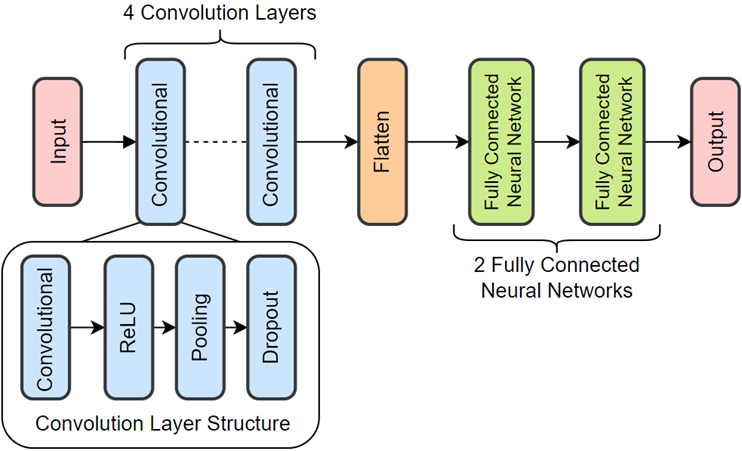

these changes were made after paramter optimisation

In [ ]:

# New Model
num_classes = 7
picture_size = 48
l2_reg = 0.001

model = Sequential()


l2_reg = 0.001

# 1. Conv Layer
model.add(Conv2D(64, (3, 3), padding='same', input_shape=(picture_size, picture_size, 1)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.3))

# 2. Conv Layer
model.add(Conv2D(64, (5, 5), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

# 3. Conv Layer
model.add(Conv2D(128, (3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.3))

# 4. Conv Layer
model.add(Conv2D(512, (3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Flatten())

# L2 regularization to the dense layers
model.add(Dense(512, kernel_regularizer=l2(l2_reg)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.3))

model.add(Dense(512, kernel_regularizer=l2(l2_reg)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(num_classes, activation='softmax'))

model.compile(optimizer=Adam(learning_rate=0.003), loss='categorical_crossentropy', metrics=['accuracy'])

research done from -https://github.com/chinhau-lim/fer_2013/blob/master/FER_2013.ipynb

changes include 
-callback_list = [PlotLossesKeras(), model_checkpoint, reduce_learning_rate, early_stop] 

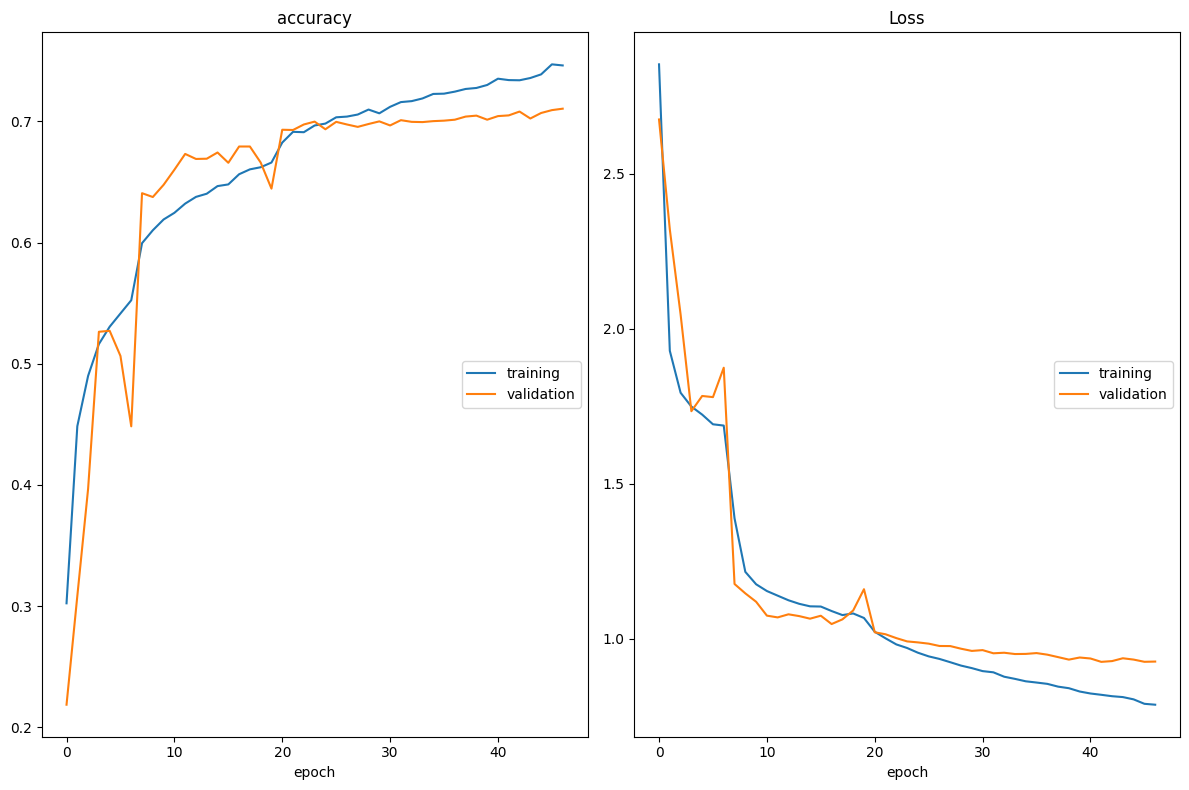

accuracy
	training         	 (min:    0.302, max:    0.747, cur:    0.746)
	validation       	 (min:    0.219, max:    0.711, cur:    0.711)
Loss
	training         	 (min:    0.787, max:    2.852, cur:    0.787)
	validation       	 (min:    0.926, max:    2.675, cur:    0.927)

Epoch 47: saving model to /content/dataset/weights.h5
Restoring model weights from the end of the best epoch: 42.
390/390 [==============================] - 22s 55ms/step - loss: 0.7875 - accuracy: 0.7462 - val_loss: 0.9266 - val_accuracy: 0.7105 - lr: 1.0000e-05
Epoch 47: early stopping


In [ ]:
num_epochs = 75
train_steps_per_epoch = train_set.n // train_set.batch_size
val_steps_per_epoch = val_set.n // val_set.batch_size

model_checkpoint = ModelCheckpoint("/content/dataset/weights.h5", monitor='val_accuracy', save_weights_only=True, mode='max', verbose=1)
reduce_learning_rate = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, min_lr=0.00001, mode='auto')

# EarlyStopping to prevent overfitting
early_stop = EarlyStopping(monitor='val_loss', patience=5, verbose=1, mode='min', restore_best_weights=True)

callback_list = [PlotLossesKeras(), model_checkpoint, reduce_learning_rate, early_stop]

history = model.fit(x=train_set, steps_per_epoch=train_steps_per_epoch, epochs=num_epochs, validation_data=val_set, callbacks=callback_list)


In [ ]:
model.save("MoodCraft.h5")
test_evaluation = model.evaluate(test_set_remaining, verbose=1)
print("Test Loss:", test_evaluation[0])
print("Test Accuracy:", test_evaluation[1])

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


51/51 [==============================] - 3s 60ms/step - loss: 0.9144 - accuracy: 0.7092
Test Loss: 0.9143760800361633
Test Accuracy: 0.7092142105102539


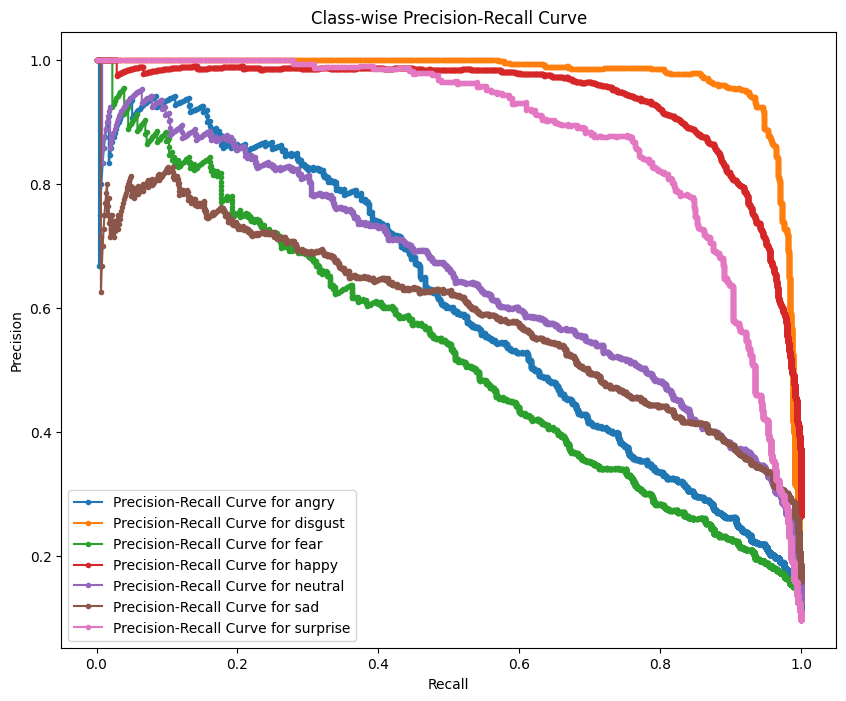

In [ ]:
from sklearn.metrics import precision_recall_curve

plt.figure(figsize=(10, 8))
for i in range(len(class_names)):
    precision, recall, _ = precision_recall_curve(binarized_true_classes[:, i], predictions[:, i])
    plt.plot(recall, precision, marker='.', label=f'Precision-Recall Curve for {class_names[i]}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Class-wise Precision-Recall Curve')
plt.legend()
plt.show()


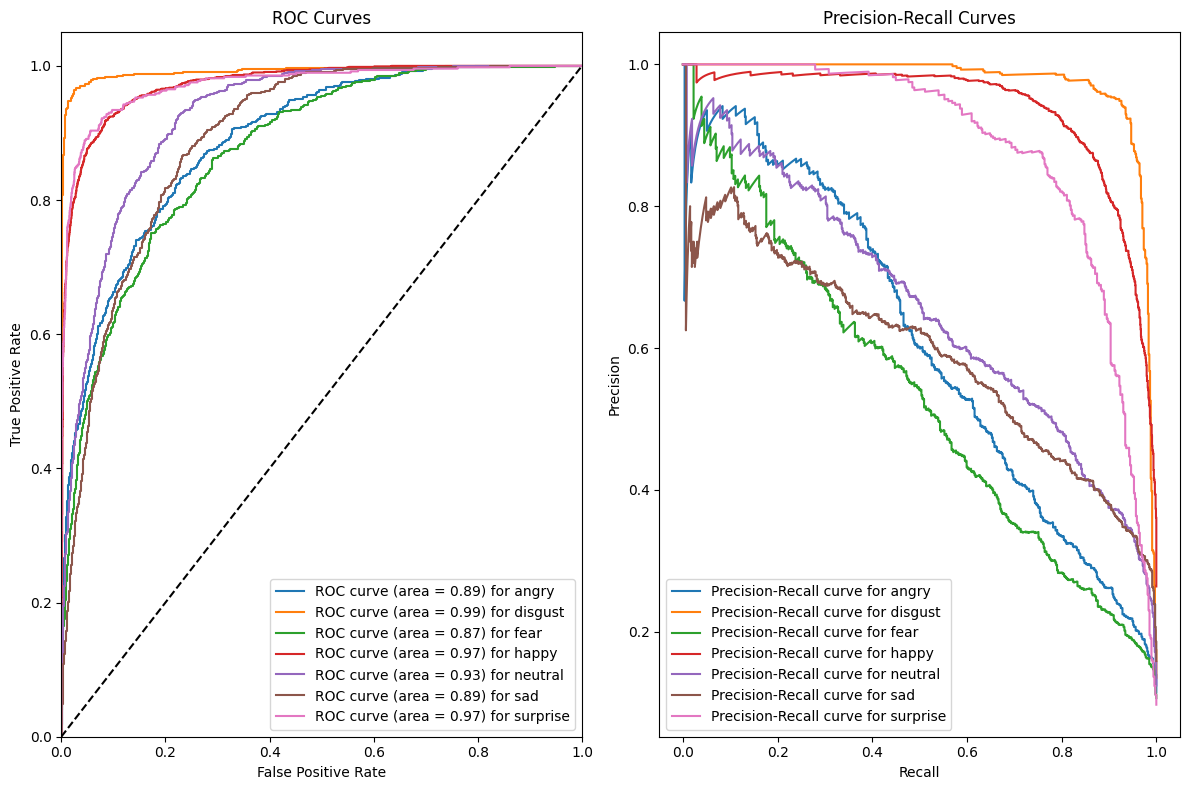

In [ ]:
from sklearn.metrics import precision_recall_curve, roc_curve, auc


plt.figure(figsize=(12, 8))


plt.subplot(1, 2, 1)
for i in range(len(class_names)):
    fpr, tpr, _ = roc_curve(binarized_true_classes[:, i], predictions[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.2f}) for {class_names[i]}')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves')
plt.legend(loc="lower right", fontsize='medium')


plt.subplot(1, 2, 2)
for i in range(len(class_names)):
    precision, recall, _ = precision_recall_curve(binarized_true_classes[:, i], predictions[:, i])
    plt.plot(recall, precision, label=f'Precision-Recall curve for {class_names[i]}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curves')
plt.legend(loc="lower left", fontsize='medium')

plt.tight_layout()
plt.show()


In [ ]:
from sklearn.metrics import roc_auc_score
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
import numpy as np


# Predict probabilities
predictions = model.predict(test_set_remaining)


true_labels = to_categorical(test_set_remaining.classes)


auc_score = roc_auc_score(true_labels, predictions, multi_class='ovr', average='weighted')
print(f"Weighted Average AUC Score: {auc_score}")


51/51 [==============================] - 2s 27ms/step
Weighted Average AUC Score: 0.9370035147206643


In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, classification_report, balanced_accuracy_score, cohen_kappa_score, log_loss
from tensorflow.keras.utils import to_categorical
import numpy as np


test_evaluation = model.evaluate(test_set_remaining, verbose=1)
print("Test Loss:", test_evaluation[0])
print("Test Accuracy:", test_evaluation[1])


predictions = model.predict(test_set_remaining)


true_classes = test_set_remaining.classes

true_labels_one_hot = to_categorical(true_classes, num_classes=np.unique(true_classes).size)


predicted_classes = np.argmax(predictions, axis=1)


auc_score = roc_auc_score(true_labels_one_hot, predictions, multi_class='ovr', average='weighted')
print(f"Weighted Average AUC Score: {auc_score}")

# Metrics
precision = precision_score(true_classes, predicted_classes, average='weighted')
recall = recall_score(true_classes, predicted_classes, average='weighted')
f1 = f1_score(true_classes, predicted_classes, average='weighted')
conf_matrix = confusion_matrix(true_classes, predicted_classes)
class_report = classification_report(true_classes, predicted_classes)
balanced_accuracy = balanced_accuracy_score(true_classes, predicted_classes)
kappa = cohen_kappa_score(true_classes, predicted_classes)
logloss = log_loss(true_labels_one_hot, predictions)

print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')
print('Confusion Matrix:\n', conf_matrix)
print('Classification Report:\n', class_report)
print(f'Balanced Accuracy: {balanced_accuracy}')
print(f"Cohen's Kappa: {kappa}")
print(f'Log Loss: {logloss}')


51/51 [==============================] - 1s 29ms/step - loss: 0.9144 - accuracy: 0.7092
Test Loss: 0.9143760800361633
Test Accuracy: 0.7092142105102539
51/51 [==============================] - 1s 27ms/step
Weighted Average AUC Score: 0.9370035147206643
Precision: 0.7145875199106879
Recall: 0.7092142002393299
F1 Score: 0.7080135655778085
Confusion Matrix:
 [[ 308   10   37   29   78   93   18]
 [  54  604    3    2    3    6    6]
 [  56    8  207   20   55  122   66]
 [  31    6   12 1121   76   46   31]
 [  30    1   20   37  438   89    8]
 [  73    4   60   42  142  466    9]
 [  14    2   15   24    9   11  412]]
Classification Report:
               precision    recall  f1-score   support

           0       0.54      0.54      0.54       573
           1       0.95      0.89      0.92       678
           2       0.58      0.39      0.47       534
           3       0.88      0.85      0.86      1323
           4       0.55      0.70      0.62       623
           5       0.56   

In [ ]:
from keras.optimizers import Adam, SGD, RMSprop
import pandas as pd
from itertools import product
from keras.models import Sequential
from keras.layers import Conv2D, BatchNormalization, Activation, MaxPooling2D, Dropout, Flatten, Dense

def grid_search(params_grid, train_set, val_set, epochs):
    results = []

    for params in product(*params_grid.values()):

        lr, dropout_rate, batch_size, dense_neurons, optimizer_name = params


        steps_per_epoch = int(0.1 * train_set.samples / batch_size)
        validation_steps = int(0.1 * val_set.samples / batch_size)


        steps_per_epoch = max(1, steps_per_epoch)
        validation_steps = max(1, validation_steps)

        
        optimizer = {'Adam': Adam(lr=lr), 'SGD': SGD(lr=lr), 'RMSprop': RMSprop(lr=lr)}.get(optimizer_name, Adam(lr=lr))
        model = build_model(lr, dropout_rate, dense_neurons)
        model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

        print(f'Testing Parameters: lr={lr}, dropout_rate={dropout_rate}, batch_size={batch_size}, dense_neurons={dense_neurons}, optimizer={optimizer_name}')

        
        history = model.fit(train_set,
                            steps_per_epoch=steps_per_epoch,
                            epochs=epochs,
                            validation_data=val_set,
                            validation_steps=validation_steps,
                            verbose=2)

      
        best_accuracy = max(history.history['val_accuracy'])
        results.append({'lr': lr, 'dropout_rate': dropout_rate, 'batch_size': batch_size, 'dense_neurons': dense_neurons, 'optimizer': optimizer_name, 'accuracy': best_accuracy})

   
    results_df = pd.DataFrame(results)


    results_df_sorted = results_df.sort_values(by='accuracy', ascending=False).reset_index(drop=True)


    print("All Parameters and Their Accuracies:")
    print(results_df_sorted)


    top_5_params = results_df_sorted.head(5)
    print("\nTop 5 Best Parameters based on Accuracy:")
    print(top_5_params)

    return results_df_sorted


def build_model(lr, dropout_rate, dense_neurons):
    model = Sequential()
    # 1st Convolution Layer
    model.add(Conv2D(64, (3,3), padding='same', input_shape=(48,48,1)))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(dropout_rate))

    # 2nd Convolution Layer
    model.add(Conv2D(128, (5,5), padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(dropout_rate))

    # 3rd Convolution Layer
    model.add(Conv2D(512, (3,3), padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(dropout_rate))

    # 4th Convolution Layer
    model.add(Conv2D(512, (3,3), padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(dropout_rate))

    model.add(Flatten())

    # Adjusted
    model.add(Dense(dense_neurons))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(dropout_rate))


    model.add(Dense(7, activation='softmax'))  

    return model

params_grid = {
    'lr': [0.001, 0.01],
    'dropout_rate': [0.25, 0.5],
    'batch_size': [32, 64], 
    'dense_neurons': [256, 512],  
    'optimizer': ['Adam', 'SGD', 'RMSprop'] 
}
results_df = grid_search(params_grid, train_set, val_set, epochs=25)
